In [1]:
import os
import glob #for loading images from a directory
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import random
import numpy as np

In [2]:
def load_dataset(image_dir):
    '''This function loads in images and their labels and places them in a list
    im_list[0][:] will be the first image-label pair in the list'''

    im_list = []
    im_list_show = []
    image_types = ["brush", "comb"]

    # Iterate through each color folder
    for im_type in image_types:

        # Iterate through each image file in each image_type folder
        # glob reads in any image with the extension "image_dir/im_type/*"
        for file in glob.glob(os.path.join(image_dir, im_type, "*")):

            # Read image name
            os.walk(".")
            im_name = file

            # Read in the image
            im = mpimg.imread(file)

            # Check if the image exists/if it's been correctly read-in
            if not im is None:
                # Append the image, and it's type (red, green, yellow) to the image list
                im_list.append((im, im_type))
                im_list_show.append((im_name,im_type))

    return im_list, im_list_show

In [3]:
image_dir = 'D:/2021/01_HSKA\SS2021/VdKI/Project/03_git/VDKICombBrush-master/resources'


brush


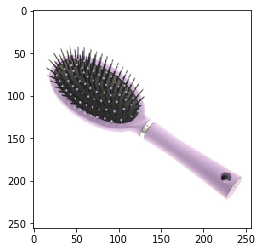

brush


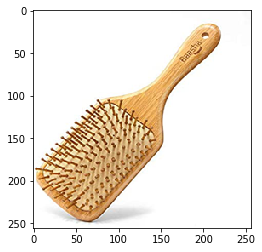

,image name,label
0,D:/2021/01_HSKA\SS2021/VdKI/Project/03_git/VDK...,brush
1,D:/2021/01_HSKA\SS2021/VdKI/Project/03_git/VDK...,brush
2,D:/2021/01_HSKA\SS2021/VdKI/Project/03_git/VDK...,brush
3,D:/2021/01_HSKA\SS2021/VdKI/Project/03_git/VDK...,brush
4,D:/2021/01_HSKA\SS2021/VdKI/Project/03_git/VDK...,brush
...,...,...
795,D:/2021/01_HSKA\SS2021/VdKI/Project/03_git/VDK...,comb
796,D:/2021/01_HSKA\SS2021/VdKI/Project/03_git/VDK...,comb
797,D:/2021/01_HSKA\SS2021/VdKI/Project/03_git/VDK...,comb
798,D:/2021/01_HSKA\SS2021/VdKI/Project/03_git/VDK...,comb


In [4]:
image_showcase = 2
image_list, image_list_show = load_dataset(image_dir)
for i in range(image_showcase):
    print(image_list[i][1])
    plt.imshow(image_list[i][0])
    plt.show()

tabel = pd.DataFrame(data = image_list_show, columns=["image name","label"])
tabel

In [5]:
def train_test_split(df, test_size):

    # if the test_size is proportion to df
    if isinstance(test_size, float):
        test_size = round(test_size * len(df)) #eg: test_size = 0.2 -> 20% x df

    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)

    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)

    return train_df, test_df

In [6]:
def check_purity(data):

    label_column = data[:, -1]
    unique_classes = np.unique(label_column)

    #unique_classes = 0 and 1 (locher, tacker) -> length = 2
    #if length only 1 -> only 1 class -> data pure -> True
    if len(unique_classes) == 1:
        return True
    else:
        return False

In [7]:
def classify_data(data):

    label_column = data[:, -1]
    unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)


    index = counts_unique_classes.argmax()
    classification = unique_classes[index]

    """
    classification =  int(classification)
    #classification = classNames[index]

    if classification == 0:
      return 'Locher'
    else:
      return 'Tacker'
    """

    return classification


In [7]:
def get_potential_splits(data):

    potential_splits = {}
    _, n_columns = data.shape
    for column_index in range(n_columns - 1):        # excluding the last column which is the label
        potential_splits[column_index] = []
        values = data[:, column_index]
        unique_values = np.unique(values)

        for index in range(len(unique_values)):
            if index != 0:
                current_value = unique_values[index]
                previous_value = unique_values[index - 1]
                potential_split = (current_value + previous_value) / 2

                potential_splits[column_index].append(potential_split)

    return potential_splits

In [ ]:
def split_data(data, split_column, split_value):

    split_column_values = data[:, split_column]

    data_below = data[split_column_values <= split_value]
    data_above = data[split_column_values >  split_value]

    return data_below, data_above


In [ ]:
def calculate_entropy(data):

    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))

    return entropy


In [ ]:
def calculate_overall_entropy(data_below, data_above):

    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_entropy =  (p_data_below * calculate_entropy(data_below)
                      + p_data_above * calculate_entropy(data_above))

    return overall_entropy


In [ ]:
def determine_best_split(data, potential_splits):

    overall_entropy = 9999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            current_overall_entropy = calculate_overall_entropy(data_below, data_above)

            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = column_index
                best_split_value = value

    return best_split_column, best_split_value


In [ ]:
def decision_tree_algorithm(df, counter=0, max_depth = 10):

    # data preparations
    if counter == 0:          #at first, data still data frame and it needs to be converted to the numpy 2Darray (without header)
        global COLUMN_HEADERS
        COLUMN_HEADERS = df.columns
        data = df.values
    else:
        data = df


    # base cases (stop condition so recursive not go infinitiv)
    if (check_purity(data)) or (counter == max_depth):
        classification = classify_data(data)
        return classification


    # recursive part
    else:
        counter += 1

        # helper functions
        potential_splits = get_potential_splits(data)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)

        # instantiate sub-tree
        feature_name= COLUMN_HEADERS[split_column]
        question = "{} <= {}".format(feature_name, split_value)
        sub_tree = {question: []}

        # find answers (recursion)
        yes_answer = decision_tree_algorithm(data_below, counter, max_depth)
        no_answer = decision_tree_algorithm(data_above, counter, max_depth)

        if yes_answer == no_answer:
          sub_tree = yes_answer
        else:
          sub_tree[question].append(yes_answer)
          sub_tree[question].append(no_answer)

        return sub_tree

In [ ]:
def classify_example(example, tree):
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split()

    # ask question
    if example[feature_name] <= float(value):
        answer = tree[question][0]
    else:
        answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer

    # recursive part
    else:
        residual_tree = answer
        return classify_example(example, residual_tree)


In [ ]:
def calculate_accuracy(df, tree):

    df["classification"] = df.apply(classify_example, axis=1, args=(tree,))
    df["classification_correct"] = df.classification == df.label

    accuracy = df["classification_correct"].mean()

    return accuracy

